1. Prepare data
2. Outline model & activation functions
3. Set appropriate optimisers and loss function
4. Learn
5. Test accuracy

In [1]:
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds

/Users/jackcook/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Data prep

In [2]:
# Get dataset plus information
mnist_dataset, mnist_info = tfds.load(name="mnist", as_supervised=True, with_info=True)

# Train/test split
mnist_train, mnist_test = mnist_dataset['train'], mnist_dataset['test']

num_validation_samples = 0.1 * mnist_info.splits['train'].num_examples
# Ensure this is an integer
num_validation_samples = tf.cast(num_validation_samples, tf.int64)

num_test_samples = mnist_info.splits['test'].num_examples
# Ensure this is an integer
num_test_samples = tf.cast(num_test_samples, tf.int64)

Then scale inputs between 0 and 1

In [3]:
def scale(image, label):
    # Take image
    image = tf.cast(image, tf.float32)
    # Value between 0 and 255, divide by 255 to get 0-1 range
    image /= 255. # Dot forces float64 output
    return image, label


# Remember we are using our training dataset for train & validation
scaled_train_and_validation_data = mnist_train.map(scale)

scaled_test_data = mnist_test.map(scale)

Shuffling means keeping the same information, but in a different order.

This helps prevent issues when batching data - ie. first 1000 examples are all target label 0, second 100 examples are 50:50 split of 0 & 1.

In [4]:
BUFFER_SIZE = 10000

- If buffer size = 1, no shuffling happens
- If buffer size >= number of samples, all samples shuffled uniformly
- Inbetween optimises for computing power (larger size = more memory)

In [5]:
shuffled_train_and_validation_data = scaled_train_and_validation_data.shuffle(BUFFER_SIZE)

# Take and skip include & omit a given number of samples respectively
validation_data = shuffled_train_and_validation_data.take(num_validation_samples)
train_data = shuffled_train_and_validation_data.skip(num_validation_samples)

We can change batch size to determine what type of gradient descent (GD) we perform:

- Size of 1: Stochastic GD
- Size of whole dataset: GD
- Inbetween: Batch GD

In [6]:
BATCH_SIZE = 100

train_data = train_data.batch(BATCH_SIZE)

# We don't need to batch validation data, as we don't BACK propogate the weights using it
# As a result it's much less computationally intensive
# We just provide the whole sample as a batch to calculate avg. loss each epoch
validation_data = validation_data.batch(num_validation_samples)

# The same goes for test data
test_data = scaled_test_data.batch(num_test_samples)

Then we take the validation inputs & targets by unpacking the tuples

In [7]:
# iter() creates an objected which can be looped through
# next() loads the next element, in this case we just have a single batch
validation_inputs, validation_targets = next(iter(validation_data))

## Model

We have 784 inputs (28 x 28 pixels, each with a value of 0 to 1), 10 output digits, and we will be using 2 hidden layers with 50 nodes in each.

In [8]:
input_size = 784
output_size = 10
hidden_layer_size = 200 # We can use different widths for each layer if we like

Next we define the model

In [9]:
model = tf.keras.Sequential([ # Stacking layers
    # Flatten turns a tensor into a vector
    # In our case, it takes a 28x28x1 tensor and produces a vector of 784
    tf.keras.layers.Flatten(input_shape=(28,28,1)),
    
    # Dense takes inputs and calculates dot product of inputs x weights
    # Then adds bias, and applies activation function
    
    # Hidden layers 1-5
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
    
    # Output layer
    tf.keras.layers.Dense(output_size, activation='softmax')
]) 

## Objective (loss) function & optimisation algorithm

We use ADAptive Moment (ADAM) estimation as optimisation algorithm. ADAM uses:

- RMSprop (Root Mean Square Propogation) scheduler (updates eta during training)
- Momentum (adding part of previous update to current update) to reflect "speed" of descent)

We use cross-entropy to see how well our model performs vs. actual digits:

- Binary cross-entropy requires binary encoding (not our case)
- Categoryical cross-entropy assumes you've one-hot encoded targets
- Sparse categorical cross-entropy applies one-hot encoding

In [10]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Training

In [11]:
NUM_EPOCHS = 5

model.fit(train_data, 
          epochs=NUM_EPOCHS,
          validation_data=(validation_inputs,validation_targets),
          validation_steps=1, # We only provide 1 batch of validation data
          verbose=2) # Only print loss for each epoch

# With a batch size of 100, each epoch has 540 updates (54,000 training samples)

Epoch 1/5
540/540 - 7s - loss: 0.2693 - accuracy: 0.9183 - val_loss: 0.1243 - val_accuracy: 0.9627
Epoch 2/5
540/540 - 6s - loss: 0.1062 - accuracy: 0.9676 - val_loss: 0.0875 - val_accuracy: 0.9737
Epoch 3/5
540/540 - 5s - loss: 0.0755 - accuracy: 0.9766 - val_loss: 0.0779 - val_accuracy: 0.9740
Epoch 4/5
540/540 - 6s - loss: 0.0553 - accuracy: 0.9818 - val_loss: 0.0607 - val_accuracy: 0.9812
Epoch 5/5
540/540 - 6s - loss: 0.0471 - accuracy: 0.9844 - val_loss: 0.0665 - val_accuracy: 0.9787


## Testing 

In [12]:
test_loss, test_accuracy = model.evaluate(test_data)

      1/Unknown - 1s 623ms/step - loss: 0.0900 - accuracy: 0.9745

In [13]:
print('Test loss: {0: .2f}. Test accuracy: {1: .2f}%'.format(test_loss, test_accuracy*100.))

Test loss:  0.09. Test accuracy:  97.45%


## Bonus!

Save images into a list

In [14]:
iterator = mnist_test.__iter__()
images=[]
for mnist_example in iterator: 
    images.append(mnist_example)

Access a single image

In [19]:
mnist_example = images[1] 
img, label = mnist_example[0], mnist_example[1]

Plot!

In [20]:
import matplotlib.pyplot as plt

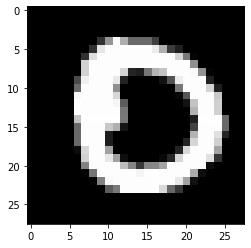

In [21]:
plt.imshow(img.numpy()[:, :, 0].astype(np.float32), cmap=plt.get_cmap("gray"))

In [22]:
img = tf.expand_dims(img, axis=0)      
img = scale(img, label)
pred = model.predict_classes(img)[0]
print('actual class:', label.numpy())
print('predicted class:', pred)

actual class: 0
predicted class: 0
